In [1]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [2]:
from datasets import load_dataset
from PIL import Image
import os
import json
from tqdm import tqdm

# Load dataset dari Hugging Face
train_dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
test_dataset = load_dataset("naver-clova-ix/cord-v2", split="test")
val_dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

# Label map
label_map = {'table': 0, 'not_table': 1}

# Folder struktur YOLOv8
base_dir = "/kaggle/working/yolo_dataset"
for split in ['train', 'val']:
    os.makedirs(f"{base_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_dir}/labels/{split}", exist_ok=True)

# Fungsi konversi quadrilateral ke YOLO format
def quad_to_yolo(quad, img_w, img_h):
    x_coords = [quad[f'x{i}'] for i in range(1, 5)]
    y_coords = [quad[f'y{i}'] for i in range(1, 5)]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x_center = (x_min + x_max) / 2.0 / img_w
    y_center = (y_min + y_max) / 2.0 / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h

    return x_center, y_center, width, height

# Label map baru
label_map = {'table': 0, 'not_table': 1}

def save_yolo_data(dataset, split):
    image_dir = os.path.join(base_dir, 'images', split)
    label_dir = os.path.join(base_dir, 'labels', split)

    for i, example in tqdm(enumerate(dataset), total=len(dataset), desc=f"Converting {split}"):
        parsed = json.loads(example['ground_truth'])
        gt_parse = parsed.get('gt_parse', {})
        image = example['image']
        img_w, img_h = image.size

        img_path = os.path.join(image_dir, f"{split}_{i:06d}.jpg")
        label_path = os.path.join(label_dir, f"{split}_{i:06d}.txt")
        image.save(img_path, format="JPEG")

        all_x, all_y = [], []

        # Kumpulkan semua koordinat quad dari item_name, quantity, price
        for item in gt_parse.get('menu', []):
            if not isinstance(item, dict):
                continue  # skip item yang bukan dict (kadang bisa berupa string/null)

            item_name = item.get('nm', '')
            if isinstance(item_name, list):
                item_name = item_name[1] if len(item_name) > 1 else item_name[0] if item_name else ''
            item_name = str(item_name).strip().lower()

            quantity = str(item.get('cnt', '')).strip().lower()
            price = str(item.get('price', '')).strip().lower()

            for line in parsed.get('valid_line', []):
                words = line.get('words', [])
                text = ' '.join([w.get('text', '') for w in words]).strip().lower()

                if text in [item_name, quantity, price]:
                    for w in words:
                        if 'quad' in w:
                            for j in range(1, 5):
                                all_x.append(w['quad'][f'x{j}'])
                                all_y.append(w['quad'][f'y{j}'])

        # Jika ada koordinat, gabungkan menjadi satu bbox besar
        if all_x and all_y:
            merged_quad = {
                'x1': min(all_x), 'y1': min(all_y),
                'x2': max(all_x), 'y2': min(all_y),
                'x3': max(all_x), 'y3': max(all_y),
                'x4': min(all_x), 'y4': max(all_y),
            }

            x_c, y_c, w, h = quad_to_yolo(merged_quad, img_w, img_h)
            yolo_line = f"{label_map['table']} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}"

            with open(label_path, "w") as f:
                f.write(yolo_line)
        else:
            open(label_path, "w").close()

# Jalankan untuk train dan val
save_yolo_data(train_dataset, "train")
save_yolo_data(test_dataset, "train")
save_yolo_data(val_dataset, "val")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Converting val: 100%|██████████| 100/100 [00:05<00:00, 18.50it/s]


In [3]:
import os
from collections import Counter

label_dir = '/kaggle/working/yolo_dataset/labels/train'  # ganti ke 'val' jika ingin validasi
label_counts = Counter()

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():  # skip baris kosong
                    class_id = int(line.split()[0])
                    label_counts[class_id] += 1

print("🔍 Total label yang ditemukan:")
for cls_id in sorted(label_counts):
    print(f"Class {cls_id}: {label_counts[cls_id]} objek")

total = sum(label_counts.values())
print(f"\n🧾 Total semua label: {total}")

🔍 Total label yang ditemukan:
Class 0: 457 objek

🧾 Total semua label: 457


In [4]:
import shutil
from roboflow import Roboflow

print("📦 Mengunduh dataset dari Roboflow...")

rf = Roboflow(api_key="QYJz4fQRw4AUwlR6v8Wm")
project_receipt = rf.workspace("apple-academy").project("splivu")
version_receipt = project_receipt.version(1)
dataset_receipt = version_receipt.download("yolov8")

project_receipt2 = rf.workspace("wideai").project("r3c3ipt")
version_receipt2 = project_receipt2.version(6)
dataset_receipt2 = version_receipt2.download("yolov8")

project_receipt3 = rf.workspace("personal2").project("uhfhlsw-y6nak")
version_receipt3 = project_receipt3.version(1)
dataset_receipt3 = version_receipt3.download("yolov8")
                
project_receipt4 = rf.workspace("testing-gsoi0").project("sds-xusqb")
version_receipt4 = project_receipt4.version(1)
dataset_receipt4 = version_receipt4.download("yolov8")
                

print("📁 Dataset: 'invoice'")
project_invoice = rf.workspace("helmetproject-vmo6o").project("invoice-pr8ex")
version_invoice = project_invoice.version(1)
dataset_invoice = version_invoice.download("yolov8")  # -> contoh: /kaggle/working/InvoiceDetection-2

project_invoice2 = rf.workspace("company-inc").project("invoicedetection-jqv45")
version_invoice2 = project_invoice2.version(2)
dataset_invoice2 = version_invoice2.download("yolov8")
                

📦 Mengunduh dataset dari Roboflow...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Splivu-1 in yolov8:: 100%|██████████| 348/348 [00:00<00:00, 4623.54it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to r3c3ipt-6 in yolov8:: 100%|██████████| 721/721 [00:00<00:00, 7808.75it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to uhfhlsw-1 in yolov8:: 100%|██████████| 840/840 [00:00<00:00, 4122.53it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to sds-1 in yolov8:: 100%|██████████| 649/649 [00:00<00:00, 7533.61it/s]

📁 Dataset: 'invoice'
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Invoice-1 in yolov8:: 100%|██████████| 1778/1778 [00:00<00:00, 8750.82it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to InvoiceDetection-2 in yolov8:: 100%|██████████| 11938/11938 [00:01<00:00, 11009.83it/s]


**MERGE BBOX AND RELABEL DATASET RECEIPT 2&3**

In [5]:
import os
import shutil
import yaml
from PIL import Image
from tqdm import tqdm

# Label map target setelah digabung menjadi 2 kelas: 'table' dan 'not_table'
label_map = {'table': 0, 'not_table': 1}

# Fungsi untuk menggabungkan beberapa bbox menjadi satu bbox besar
def merge_bboxes(bboxes):
    x_min = min(b[0] for b in bboxes)
    y_min = min(b[1] for b in bboxes)
    x_max = max(b[2] for b in bboxes)
    y_max = max(b[3] for b in bboxes)
    return [x_min, y_min, x_max, y_max]

# Fungsi untuk memproses dataset: copy gambar, gabungkan bbox, simpan label baru
def process_dataset(dataset_dir, output_dir):
    # Baca data.yaml
    data_yaml_path = os.path.join(dataset_dir, "data.yaml")
    with open(data_yaml_path, "r") as f:
        data_yaml_content = yaml.safe_load(f)

    # Mapping class_id ke nama label berdasarkan data.yaml
    class_id_to_name = {i: name for i, name in enumerate(data_yaml_content['names'])}

    # Tentukan label yang ingin digabungkan
    target_labels = ["Item", "Price", "Quantity", "Sub Price"]

    # Proses data untuk setiap split: train dan valid
    for split in ['train', 'valid']:
        images_dir = os.path.join(dataset_dir, split, "images")
        labels_dir = os.path.join(dataset_dir, split, "labels")

        output_images_dir = os.path.join(output_dir, "images", split)
        output_labels_dir = os.path.join(output_dir, "labels", split)
        os.makedirs(output_images_dir, exist_ok=True)
        os.makedirs(output_labels_dir, exist_ok=True)

        for label_file in tqdm(os.listdir(labels_dir), desc=f"Processing {split} data"):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(labels_dir, label_file)
            image_filename = label_file.replace(".txt", ".jpg")
            image_path = os.path.join(images_dir, image_filename)
            output_image_path = os.path.join(output_images_dir, image_filename)
            output_label_path = os.path.join(output_labels_dir, label_file)

            # Salin gambar ke direktori output
            shutil.copy(image_path, output_image_path)

            with open(label_path, "r") as f:
                lines = f.readlines()

            bboxes = []
            image = Image.open(image_path)
            img_w, img_h = image.size

            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Konversi bbox dari format YOLO ke koordinat absolut
                x_min = (x_center - width / 2) * img_w
                y_min = (y_center - height / 2) * img_h
                x_max = (x_center + width / 2) * img_w
                y_max = (y_center + height / 2) * img_h

                label_name = class_id_to_name.get(class_id, None)

                if label_name in target_labels:
                    bboxes.append([x_min, y_min, x_max, y_max])
                # Abaikan label lainnya

            if bboxes:
                merged_bbox = merge_bboxes(bboxes)
                # Konversi kembali ke format YOLO (relatif)
                x_center = ((merged_bbox[0] + merged_bbox[2]) / 2) / img_w
                y_center = ((merged_bbox[1] + merged_bbox[3]) / 2) / img_h
                width = (merged_bbox[2] - merged_bbox[0]) / img_w
                height = (merged_bbox[3] - merged_bbox[1]) / img_h

                with open(output_label_path, "w") as f:
                    f.write(f"{label_map['table']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            else:
                # Jika tidak ada bbox target, buat file label kosong
                open(output_label_path, "w").close()


In [6]:
# Direktori output
output_dir = "/kaggle/working/yolo_dataset"

# Proses kedua dataset
process_dataset("/kaggle/working/r3c3ipt-6", output_dir)
process_dataset("/kaggle/working/uhfhlsw-1", output_dir)

Processing valid data: 100%|██████████| 8/8 [00:00<00:00, 1959.15it/s]


**MERGE BBOX AND RELABEL DATASET RECEIPT 4**

In [7]:
import os
import shutil
import yaml
from PIL import Image
from tqdm import tqdm

# Label map target setelah digabung menjadi 2 kelas: 'table' dan 'not_table'
label_map = {'table': 0, 'not_table': 1}

# Fungsi untuk menggabungkan beberapa bbox menjadi satu bbox besar
def merge_bboxes(bboxes):
    x_min = min(b[0] for b in bboxes)
    y_min = min(b[1] for b in bboxes)
    x_max = max(b[2] for b in bboxes)
    y_max = max(b[3] for b in bboxes)
    return [x_min, y_min, x_max, y_max]

# Fungsi untuk memproses dataset: copy gambar, gabungkan bbox, simpan label baru
def process_dataset(dataset_dir, output_dir):
    # Baca data.yaml
    data_yaml_path = os.path.join(dataset_dir, "data.yaml")
    with open(data_yaml_path, "r") as f:
        data_yaml_content = yaml.safe_load(f)

    # Mapping class_id ke nama label berdasarkan data.yaml
    class_id_to_name = {i: name for i, name in enumerate(data_yaml_content['names'])}

    # Label yang ingin digabungkan
    target_labels = [
        "==============================",
        "Roboflow is an end-to-end computer vision platform that helps you",
        "This dataset was exported via roboflow.com on November 24, 2024 at 1:47 AM GMT", 
        "r3c3ipt - v6 2023-08-25 10:58am" 
    ]


    # Proses data untuk setiap split: train dan valid
    for split in ['train', 'valid']:
        images_dir = os.path.join(dataset_dir, split, "images")
        labels_dir = os.path.join(dataset_dir, split, "labels")

        output_images_dir = os.path.join(output_dir, "images", split)
        output_labels_dir = os.path.join(output_dir, "labels", split)
        os.makedirs(output_images_dir, exist_ok=True)
        os.makedirs(output_labels_dir, exist_ok=True)

        for label_file in tqdm(os.listdir(labels_dir), desc=f"Processing {split} data"):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(labels_dir, label_file)
            image_filename = label_file.replace(".txt", ".jpg")
            image_path = os.path.join(images_dir, image_filename)
            output_image_path = os.path.join(output_images_dir, image_filename)
            output_label_path = os.path.join(output_labels_dir, label_file)

            # Salin gambar ke direktori output
            shutil.copy(image_path, output_image_path)

            with open(label_path, "r") as f:
                lines = f.readlines()

            bboxes = []
            image = Image.open(image_path)
            img_w, img_h = image.size

            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Konversi bbox dari format YOLO ke koordinat absolut
                x_min = (x_center - width / 2) * img_w
                y_min = (y_center - height / 2) * img_h
                x_max = (x_center + width / 2) * img_w
                y_max = (y_center + height / 2) * img_h

                label_name = class_id_to_name.get(class_id, None)

                if label_name in target_labels:
                    bboxes.append([x_min, y_min, x_max, y_max])
                # Abaikan label lainnya

            if bboxes:
                merged_bbox = merge_bboxes(bboxes)
                # Konversi kembali ke format YOLO (relatif)
                x_center = ((merged_bbox[0] + merged_bbox[2]) / 2) / img_w
                y_center = ((merged_bbox[1] + merged_bbox[3]) / 2) / img_h
                width = (merged_bbox[2] - merged_bbox[0]) / img_w
                height = (merged_bbox[3] - merged_bbox[1]) / img_h

                with open(output_label_path, "w") as f:
                    f.write(f"{label_map['table']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            else:
                # Jika tidak ada bbox target, buat file label kosong
                open(output_label_path, "w").close()

# Proses dataset
process_dataset(dataset_receipt4.location, output_dir)


Processing valid data: 100%|██████████| 16/16 [00:00<00:00, 2335.03it/s]


**RELABEL OTHER DATASET**

In [8]:
import yaml

def cek_label_names(data_yaml_path):
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    names = data.get('names', [])
    print("📋 Daftar Label:")
    for i, name in enumerate(names):
        print(f"  {i}: {name}")
    return names

data_yaml_invoice = os.path.join(dataset_invoice.location, "data.yaml")
label_invoice = cek_label_names(data_yaml_invoice)

data_yaml_invoice2 = os.path.join(dataset_invoice2.location, "data.yaml")
label_invoice2 = cek_label_names(data_yaml_invoice2)

data_yaml_receipt = os.path.join(dataset_receipt.location, "data.yaml")
label_receipt = cek_label_names(data_yaml_receipt)

📋 Daftar Label:
  0: -
  1: Invoice- NER detection - v1 2024-03-10 8-52am
📋 Daftar Label:
  0: CLIENT
  1: COMPANY
  2: CUSTOMER
  3: Customer
  4: CustomerName
  5: INVOICE
  6: PAYMENT
  7: TABLE
  8: TOTAL
📋 Daftar Label:
  0: receipt


In [9]:
def filter_labels_keep_only_class_0(label_dir, keep_class_id=0):
    kept_files = 0
    removed_lines = 0

    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        if path.endswith('.txt') and os.path.isfile(path):
            with open(path, 'r') as f:
                lines = f.readlines()

            new_lines = [line for line in lines if line.strip().startswith(str(keep_class_id) + ' ')]
            removed = len(lines) - len(new_lines)

            if new_lines:
                with open(path, 'w') as f:
                    f.writelines(new_lines)
                kept_files += 1
                removed_lines += removed
            else:
                os.remove(path)  # Hapus file jika semua label dihapus

    print(f"✅ {kept_files} file disimpan dengan hanya label class {keep_class_id}.")
    print(f"🗑️ {removed_lines} baris label lain dibuang.")


# Dataset InvoiceDetection hanya pakai label "-"
filter_labels_keep_only_class_0(os.path.join(dataset_invoice.location, 'train', 'labels'))
filter_labels_keep_only_class_0(os.path.join(dataset_invoice.location, 'valid', 'labels'))
filter_labels_keep_only_class_0(os.path.join(dataset_invoice2.location, 'train', 'labels'), 7)
filter_labels_keep_only_class_0(os.path.join(dataset_invoice2.location, 'valid', 'labels'), 7)
filter_labels_keep_only_class_0(os.path.join(dataset_receipt.location, 'train', 'labels'))
filter_labels_keep_only_class_0(os.path.join(dataset_receipt.location, 'valid', 'labels'))

✅ 693 file disimpan dengan hanya label class 0.
🗑️ 4934 baris label lain dibuang.
✅ 65 file disimpan dengan hanya label class 0.
🗑️ 507 baris label lain dibuang.
✅ 976 file disimpan dengan hanya label class 7.
🗑️ 0 baris label lain dibuang.
✅ 62 file disimpan dengan hanya label class 7.
🗑️ 0 baris label lain dibuang.
✅ 146 file disimpan dengan hanya label class 0.
🗑️ 0 baris label lain dibuang.
✅ 15 file disimpan dengan hanya label class 0.
🗑️ 0 baris label lain dibuang.


In [10]:
def relabel_class_0_to_target(label_dir, new_class_id=0):
    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        if path.endswith('.txt') and os.path.isfile(path):
            with open(path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if parts[0] == '0':
                    parts[0] = str(new_class_id)
                    new_lines.append(' '.join(parts))

            with open(path, 'w') as f:
                f.write('\n'.join(new_lines))

relabel_class_0_to_target(os.path.join(dataset_invoice.location, 'train', 'labels'), 0)
relabel_class_0_to_target(os.path.join(dataset_invoice.location, 'valid', 'labels'), 0)
relabel_class_0_to_target(os.path.join(dataset_invoice2.location, 'train', 'labels'), 0)
relabel_class_0_to_target(os.path.join(dataset_invoice2.location, 'valid', 'labels'), 0)
relabel_class_0_to_target(os.path.join(dataset_receipt.location, 'train', 'labels'), 0)
relabel_class_0_to_target(os.path.join(dataset_receipt.location, 'valid', 'labels'), 0)

In [11]:
# Struktur folder benar sesuai format Roboflow
for split in ['train', 'valid']: 
    for subfolder in ['images', 'labels']:
        src1 = os.path.join(dataset_receipt.location, split, subfolder)
        src2 = os.path.join(dataset_invoice.location, split, subfolder)
        src3 = os.path.join(dataset_invoice2.location, split, subfolder)
        dst = os.path.join(base_dir, subfolder, split)

        os.makedirs(dst, exist_ok=True)

        for i, src in enumerate([src1, src2, src3], start=1):
            if os.path.exists(src):
                files = [f for f in os.listdir(src) if os.path.isfile(os.path.join(src, f))]
                print(f"🔄 Menyalin {len(files)} file dari sumber {i} ({split}/{subfolder})")
                for f in files:
                    shutil.copy(os.path.join(src, f), os.path.join(dst, f))
            else:
                print(f"⚠️ Folder tidak ditemukan: {src}")

print("✅ Selesai menggabungkan dataset.")

🔄 Menyalin 146 file dari sumber 1 (train/images)
🔄 Menyalin 774 file dari sumber 2 (train/images)
🔄 Menyalin 5310 file dari sumber 3 (train/images)
🔄 Menyalin 146 file dari sumber 1 (train/labels)
🔄 Menyalin 693 file dari sumber 2 (train/labels)
🔄 Menyalin 976 file dari sumber 3 (train/labels)
🔄 Menyalin 15 file dari sumber 1 (valid/images)
🔄 Menyalin 73 file dari sumber 2 (valid/images)
🔄 Menyalin 324 file dari sumber 3 (valid/images)
🔄 Menyalin 15 file dari sumber 1 (valid/labels)
🔄 Menyalin 65 file dari sumber 2 (valid/labels)
🔄 Menyalin 62 file dari sumber 3 (valid/labels)
✅ Selesai menggabungkan dataset.


In [12]:
import yaml
import os

# Pastikan direktori /kaggle/working/ sudah ada (di Kaggle otomatis ada)
dataset_yaml = {
    'path': '/kaggle/working/yolo_dataset',
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,
    'names': {
        0: 'table',
        1: 'not_table'
    }
}

# Buat folder yolo_dataset jika belum ada
os.makedirs('/kaggle/working/yolo_dataset', exist_ok=True)

# Simpan dataset.yaml
with open('/kaggle/working/yolo_dataset/dataset.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f, sort_keys=False)

In [13]:
import os
from collections import Counter

label_dir = '/kaggle/working/yolo_dataset/labels/train'  # ganti ke 'val' jika ingin validasi
label_counts = Counter()

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():  # skip baris kosong
                    class_id = int(line.split()[0])
                    label_counts[class_id] += 1

print("🔍 Total label yang ditemukan:")
for cls_id in sorted(label_counts):
    print(f"Class {cls_id}: {label_counts[cls_id]} objek")

total = sum(label_counts.values())
print(f"\n🧾 Total semua label: {total}")

🔍 Total label yang ditemukan:
Class 0: 2335 objek

🧾 Total semua label: 2335


In [14]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

results = model.train(
    data = '/kaggle/working/yolo_dataset/dataset.yaml',
    batch = 24,
    epochs = 35,
    device = 0,
    lr0 = 3e-4,
    optimizer='AdamW',
    imgsz = 640,
    save_period = 10
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 124MB/s]


Ultralytics 8.3.139 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

100%|██████████| 755k/755k [00:00<00:00, 26.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 118MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 639.3±473.7 MB/s, size: 47.1 KB)


train: Scanning /kaggle/working/yolo_dataset/labels/train... 3630 images, 5734 backgrounds, 0 corrupt: 100%|██████████| 8045/8045 [00:03<00:00, 2101.12it/s]


train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 2335. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 457.8±304.8 MB/s, size: 143.8 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val... 100 images, 46 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1745.82it/s]

val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      2.86G      1.454      2.608      1.415          2        640: 100%|██████████| 336/336 [01:17<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all        100         54      0.637      0.814      0.771      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      3.17G      1.234      1.644      1.258          5        640: 100%|██████████| 336/336 [01:14<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all        100         54      0.379      0.444      0.424      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      3.18G      1.167      1.478      1.222          1        640: 100%|██████████| 336/336 [01:14<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all        100         54      0.759      0.852      0.868      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      3.18G      1.106      1.341      1.198          4        640: 100%|██████████| 336/336 [01:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all        100         54      0.831      0.685      0.849      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      3.18G      1.062      1.236      1.158          3        640: 100%|██████████| 336/336 [01:13<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all        100         54       0.89      0.833      0.897      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      3.18G      1.026      1.154       1.15          3        640: 100%|██████████| 336/336 [01:13<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all        100         54      0.769      0.927      0.924       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      3.18G      0.989      1.114      1.132          3        640: 100%|██████████| 336/336 [01:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all        100         54      0.924      0.815       0.95      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      3.18G     0.9765       1.04      1.115          2        640: 100%|██████████| 336/336 [01:13<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all        100         54      0.816      0.902       0.93      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      3.18G     0.9249       1.02      1.094          0        640: 100%|██████████| 336/336 [01:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all        100         54       0.89      0.899      0.939      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      3.18G     0.9076     0.9619      1.071          1        640: 100%|██████████| 336/336 [01:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all        100         54      0.859      0.903      0.941       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      3.18G     0.8929     0.9437      1.068          4        640: 100%|██████████| 336/336 [01:14<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

                   all        100         54      0.866      0.907      0.967      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      3.18G     0.8763     0.9364      1.063          5        640: 100%|██████████| 336/336 [01:15<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

                   all        100         54      0.886      0.907      0.958       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      3.18G     0.8653     0.8969      1.054          5        640: 100%|██████████| 336/336 [01:14<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all        100         54      0.935      0.798      0.952      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      3.18G     0.8274      0.852      1.035          2        640: 100%|██████████| 336/336 [01:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all        100         54      0.818      0.914      0.947      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      3.18G     0.8226     0.8238      1.038          4        640: 100%|██████████| 336/336 [01:14<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all        100         54      0.852      0.959       0.94      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      3.18G     0.8179     0.8354       1.03          1        640: 100%|██████████| 336/336 [01:14<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all        100         54      0.892      0.926      0.965      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      3.18G     0.7927     0.8238      1.029          8        640: 100%|██████████| 336/336 [01:14<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all        100         54      0.924        0.9      0.957      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      3.18G     0.7771     0.7873      1.016          2        640: 100%|██████████| 336/336 [01:14<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all        100         54      0.891      0.908      0.946      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      3.18G     0.7755     0.7883      1.014          3        640: 100%|██████████| 336/336 [01:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]

                   all        100         54      0.978      0.833      0.958      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      3.18G     0.7564     0.7666      1.012          2        640: 100%|██████████| 336/336 [01:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all        100         54       0.96       0.89       0.98      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      3.19G     0.7456      0.735      1.002          3        640: 100%|██████████| 336/336 [01:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all        100         54      0.895      0.945      0.978      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      3.19G     0.7433     0.7231      1.002          4        640: 100%|██████████| 336/336 [01:14<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all        100         54      0.951      0.889      0.956      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      3.19G     0.7179     0.7051     0.9901          5        640: 100%|██████████| 336/336 [01:14<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all        100         54      0.958      0.907      0.976       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      3.19G     0.7021     0.6987     0.9917          2        640: 100%|██████████| 336/336 [01:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all        100         54      0.922       0.87      0.953      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      3.19G     0.7082     0.6998     0.9898          4        640: 100%|██████████| 336/336 [01:14<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all        100         54      0.896      0.953      0.972       0.84


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      3.19G      0.646     0.6545     0.9792          2        640: 100%|██████████| 336/336 [01:14<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all        100         54      0.909      0.922      0.962      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      3.19G     0.6258     0.6042     0.9664          1        640: 100%|██████████| 336/336 [01:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all        100         54      0.882      0.973      0.978      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      3.19G     0.6014     0.5826     0.9584          1        640: 100%|██████████| 336/336 [01:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

                   all        100         54      0.961      0.903      0.971      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      3.19G     0.5947     0.5786      0.947          3        640: 100%|██████████| 336/336 [01:13<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]

                   all        100         54      0.939      0.944      0.982      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      3.19G     0.5687     0.5569     0.9369          0        640: 100%|██████████| 336/336 [01:12<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

                   all        100         54      0.935      0.926      0.979      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      3.19G     0.5608     0.5374     0.9309          0        640: 100%|██████████| 336/336 [01:12<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

                   all        100         54      0.913      0.975      0.981      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      3.19G     0.5552     0.5366     0.9411          1        640: 100%|██████████| 336/336 [01:12<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]

                   all        100         54      0.927      0.981      0.986       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      3.19G     0.5301     0.5276     0.9151          0        640: 100%|██████████| 336/336 [01:12<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]

                   all        100         54      0.895      0.981      0.981      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      3.19G     0.5252     0.5091     0.9213          2        640: 100%|██████████| 336/336 [01:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.78it/s]

                   all        100         54      0.913      0.974      0.985      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      3.19G     0.5173     0.5111     0.9078          1        640: 100%|██████████| 336/336 [01:12<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all        100         54      0.929      0.981      0.986      0.906



35 epochs completed in 0.727 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


                   all        100         54      0.929      0.981      0.986      0.903
                 table         54         54      0.929      0.981      0.986      0.903


invalid value encountered in less
invalid value encountered in less


Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


In [15]:
import shutil

# Path folder yang ingin dikompres (misalnya hasil training YOLOv8)
folder_path = "/kaggle/working/runs/detect/train"
zip_path = "/kaggle/working/train_results.zip"

# Buat zip dari folder
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

print("Folder berhasil dikompres ke:", zip_path)

Folder berhasil dikompres ke: /kaggle/working/train_results.zip


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Path ke hasil training
results_csv_path = "/kaggle/working/runs/detect/train/results.csv"

# Baca file CSV
df = pd.read_csv(results_csv_path)

# Tampilkan kolom-kolom tersedia
print(df.columns)

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


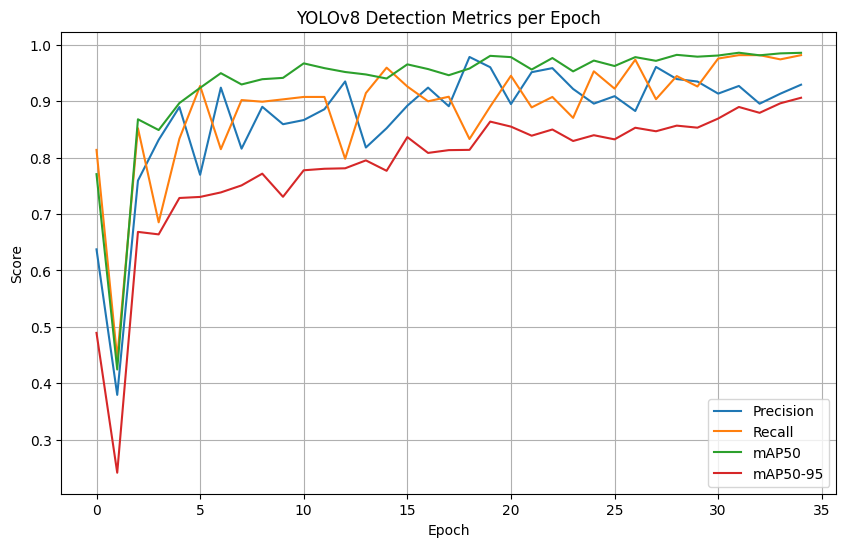

In [17]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Now, try plotting again
plt.figure(figsize=(10,6))
plt.plot(df['metrics/precision(B)'], label='Precision')
plt.plot(df['metrics/recall(B)'], label='Recall')
plt.plot(df['metrics/mAP50(B)'], label='mAP50')
plt.plot(df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.title("YOLOv8 Detection Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

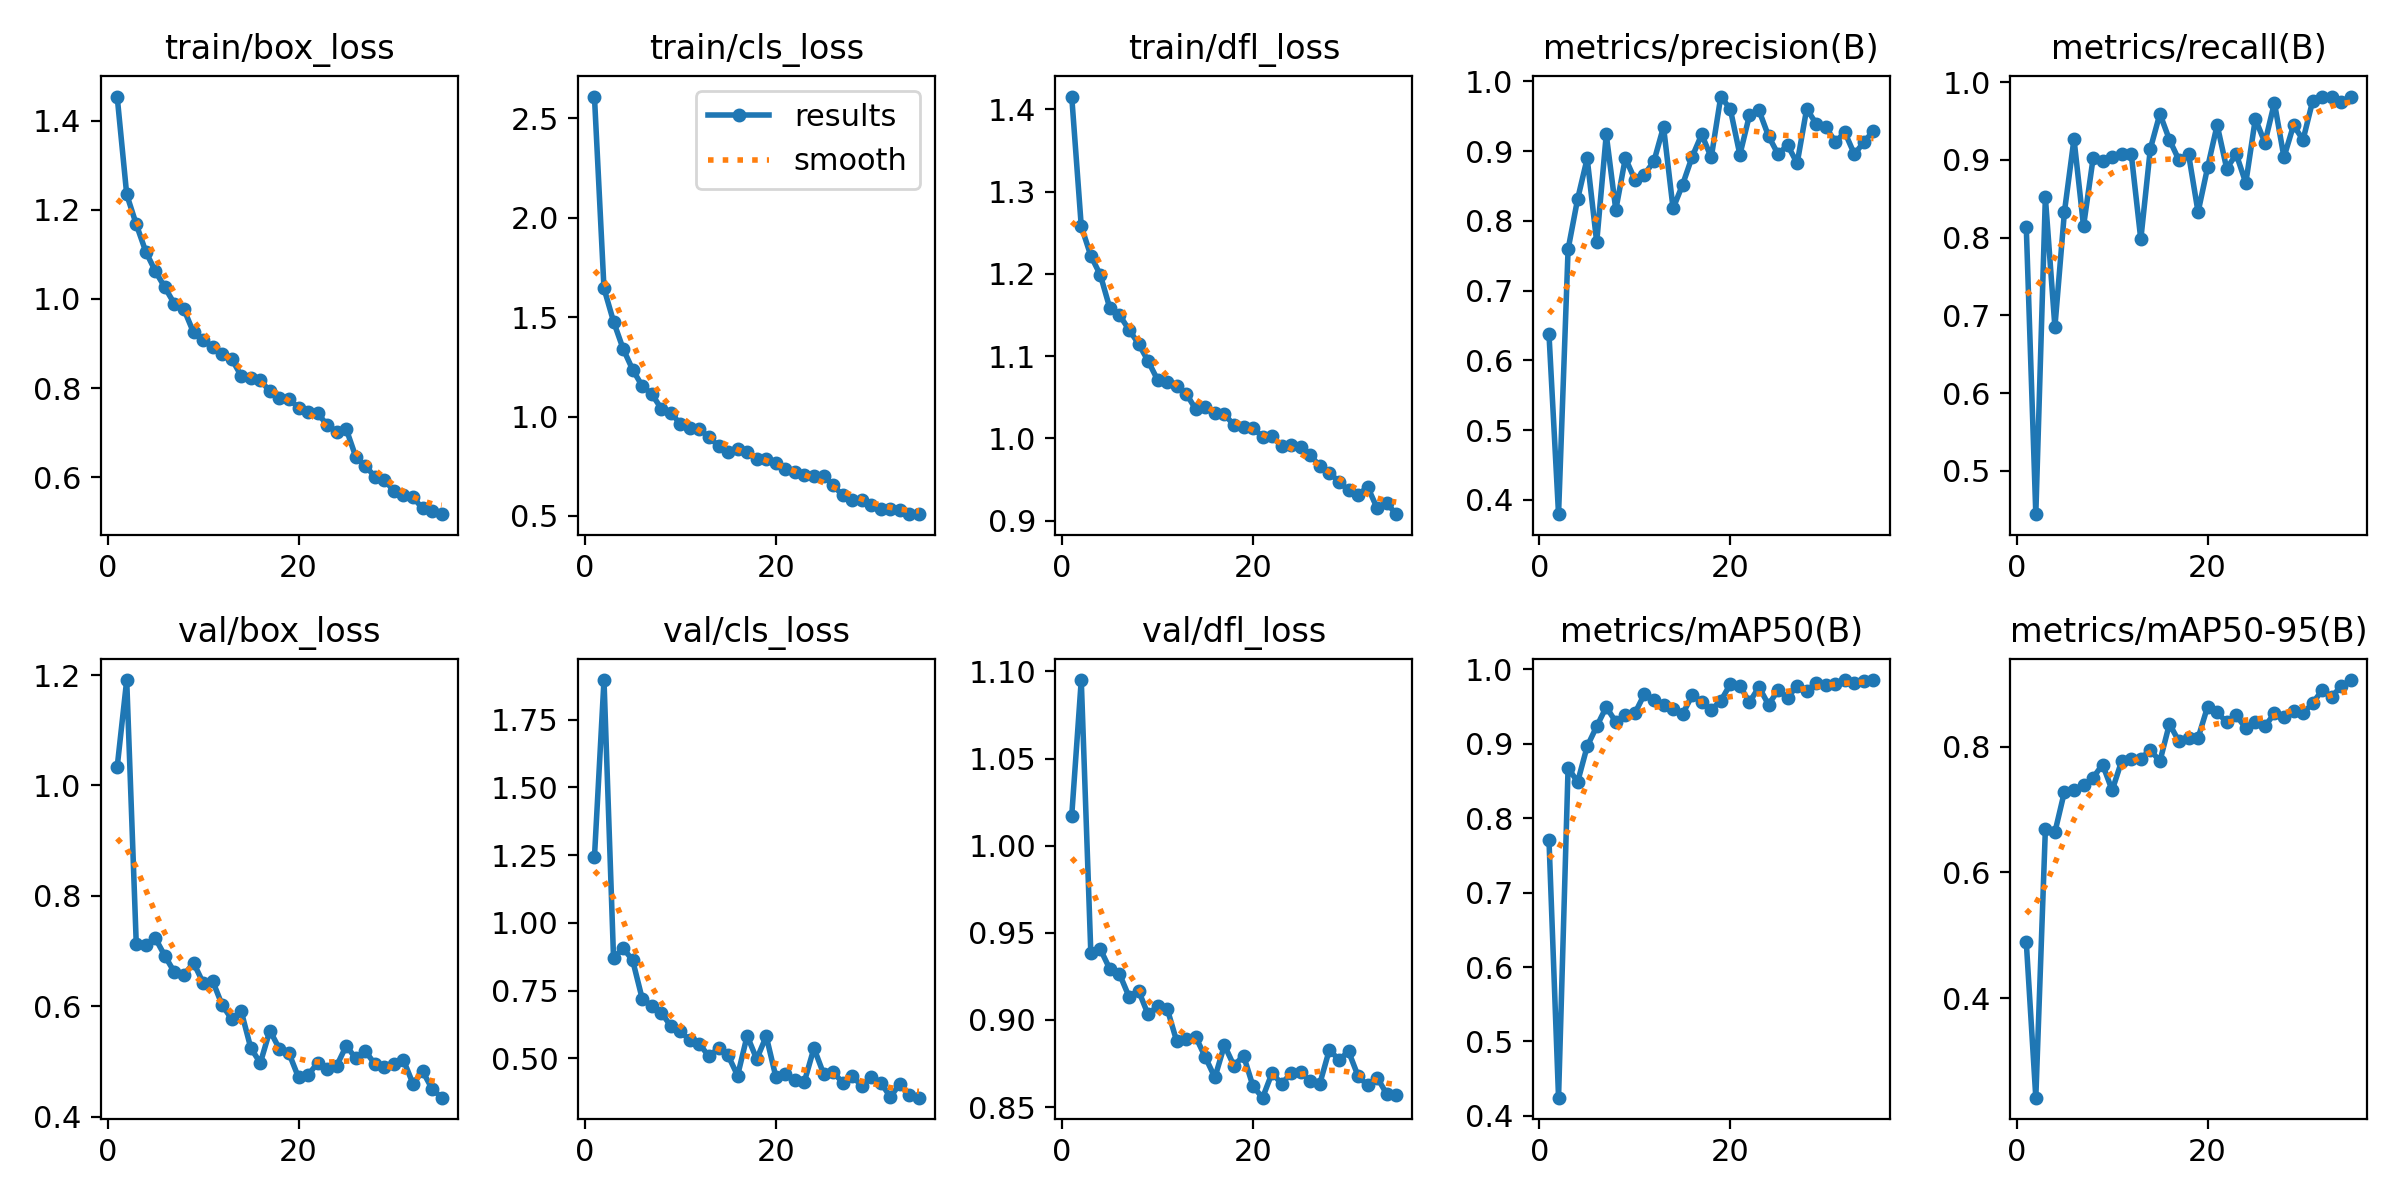

In [18]:
from PIL import Image
from IPython.display import display

img = Image.open("/kaggle/working/runs/detect/train/results.png")
display(img)

In [19]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")


0: 640x640 1 table, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


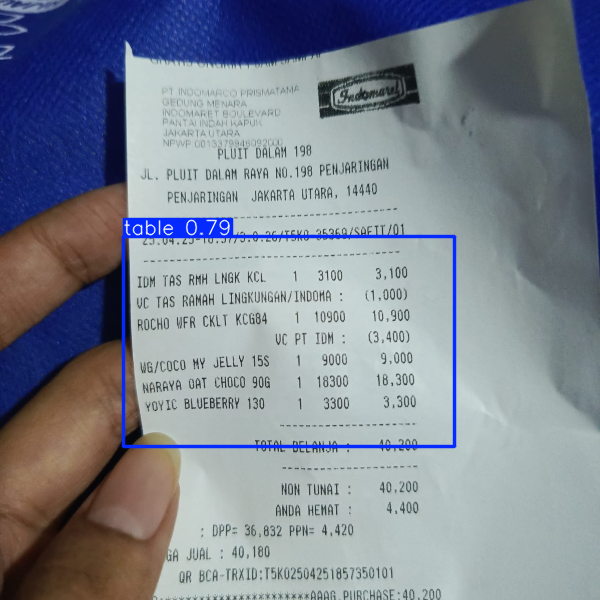

In [26]:
import cv2
import numpy as np

dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
# image_path = dataset[12]['image']  # Sudah dalam bentuk PIL.Image
image_path = Image.open("/kaggle/input/contoh/contoh-1.jpeg")
image_np = cv2.cvtColor(np.array(image_path), cv2.COLOR_RGB2BGR)
image_resized = cv2.resize(image_np, (600, 600))

results = model(image_resized)  # Ganti dengan path gambar kamu


# Tampilkan hasilnya
results[0].show()

In [21]:
for result in results:
    boxes = result.boxes  # bounding boxes
    probs = result.probs  # klasifikasi probabilitas (jika ada)
    print(boxes.xyxy)     # koordinat [x1, y1, x2, y2]
    print(boxes.conf)     # confidence score
    print(boxes.cls)      # class index

tensor([[123.4077, 236.0309, 454.3456, 446.9352]], device='cuda:0')
tensor([0.7932], device='cuda:0')
tensor([0.], device='cuda:0')


In [22]:
for box in results[0].boxes:
    print(box.xyxy, box.conf, box.cls)

tensor([[123.4077, 236.0309, 454.3456, 446.9352]], device='cuda:0') tensor([0.7932], device='cuda:0') tensor([0.], device='cuda:0')
